In [1]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
sns.set_style('darkgrid')

In [2]:
%%time
from fastparquet import ParquetFile
import s3fs
import boto3
import concurrent.futures
import urllib.request

WORKERS = 50 # Number of concurrent data download threads
YEARS = list(i for i in range(2001, 2019))
# Previous notebook showed no appreciable difference btw. 1000 and 10000 class weighting,
# when the proper threshold is chosen.
WEIGHTS = [10000]
dfs = []

# Going to spawn multiple threads to download concurrently,
# so define a function here
def get_dataframe_from_s3(key, weight):
    return (ParquetFile(s3_url.format(key), open_with=myopen).to_pandas(), weight)

print("Processing years:", YEARS)
for year in tqdm(YEARS):
    s3_keys = []
    prediction_url = "wildfire_capstone/logistic_regression_predictions/with_probs/"\
                     "year={year}/weight={weight}/month={month}/"
    s3_client = boto3.client('s3')
    s3_resource = boto3.resource('s3')
    s3_keys = [(item.key, weight)
               for weight in WEIGHTS
               for month in [str(m).zfill(2) for m in range(1, 13)]
               for item in s3_resource.Bucket('dse-cohort5-group5').objects.filter(
                   Prefix=prediction_url.format(year=year, weight=weight, month=month))
               if item.key.endswith('.parquet') or True]
    # display(s3_keys[:3])
    s3 = s3fs.S3FileSystem()
    s3.invalidate_cache()
    myopen = s3.open
    s3_url = 's3://dse-cohort5-group5/{}'

    # We can use a with statement to ensure threads are cleaned up promptly
    with concurrent.futures.ThreadPoolExecutor(max_workers=WORKERS) as executor:
        future_dfs = [executor.submit(get_dataframe_from_s3, key, weight) for (key, weight) in s3_keys]
        total = len(future_dfs)
        for future in tqdm(concurrent.futures.as_completed(future_dfs), total=total):
            dfs.append(future.result())

Processing years: [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]




Wall time: 23min 57s


In [3]:
%%time
for (df, weight) in dfs:
    df.date = pd.to_datetime(df.date)
    df.set_index(['date', 'latitude', 'longitude'], inplace=True)
    df['weight'] = weight
    df['probability_of_fire'] = df['probability.values'].apply(lambda x: x[1])

complete_df = pd.concat([df for (df, weight) in dfs])
print(complete_df.shape)
complete_df.head()

(5850860, 10)
Wall time: 4min 15s


fire_occurred  acres_burned  year day  \
date       latitude  longitude                                            
2001-01-03 32.816667 -116.683333              1  10438.019531  2001  03   
           32.775000 -116.850000              1  10438.019531  2001  03   
                     -116.766667              1  10438.019531  2001  03   
                     -116.725000              1  10438.019531  2001  03   
           32.733333 -116.808333              1  10438.019531  2001  03   

                                  probability.type  probability.size  \
date       latitude  longitude                                         
2001-01-03 32.816667 -116.683333                 1               NaN   
           32.775000 -116.850000                 1               NaN   
                     -116.766667                 1               NaN   
                     -116.725000                 1               NaN   
           32.733333 -116.808333                 1               NaN   

                                 probability.indices  \
date       latitude  longitude                         
2001-01-03 32.816667 -116.683333                  []   
           32.775000 -116.850000                  []   
                     -116.766667                  []   
                     -116.725000                  []   
           32.733333 -116.808333                  []   

                                                         probability.values  \
date       latitude  longitude                                                
2001-01-03 32.816667 -116.683333  [0.8649854469016677, 0.13501455309833235]   
           32.775000 -116.850000  [0.5676852881424038, 0.43231471185759623]   
                     -116.766667   [0.707387364704277, 0.29261263529572307]   
                     -116.725000  [0.8080413992813199, 0.19195860071868015]   
           32.733333 -116.808333   [0.735643086272604, 0.26435691372739595]   

                                  weight  probability_of_fire  
date       latitude  longitude                                 
2001-01-03 32.816667 -116.683333   10000             0.135015  
           32.775000 -116.850000   10000             0.432315  
                     -116.766667   10000             0.292613  
                     -116.725000   10000             0.191959  
           32.733333 -116.808333   10000             0.264357

In [4]:
%%time
# Use to checkpoint data
complete_df.to_parquet("lr_preds.parquet.gz", compression='gzip')

Wall time: 15.1 s


In [5]:
%%time
complete_df = pd.read_parquet("lr_preds.parquet.gz")
print(complete_df.shape)
complete_df.head()

(5850860, 10)
Wall time: 5.48 s


fire_occurred  acres_burned  year day  \
date       latitude  longitude                                            
2001-01-03 32.816667 -116.683333              1  10438.019531  2001  03   
           32.775000 -116.850000              1  10438.019531  2001  03   
                     -116.766667              1  10438.019531  2001  03   
                     -116.725000              1  10438.019531  2001  03   
           32.733333 -116.808333              1  10438.019531  2001  03   

                                  probability.type  probability.size  \
date       latitude  longitude                                         
2001-01-03 32.816667 -116.683333                 1               NaN   
           32.775000 -116.850000                 1               NaN   
                     -116.766667                 1               NaN   
                     -116.725000                 1               NaN   
           32.733333 -116.808333                 1               NaN   

                                 probability.indices  \
date       latitude  longitude                         
2001-01-03 32.816667 -116.683333                  []   
           32.775000 -116.850000                  []   
                     -116.766667                  []   
                     -116.725000                  []   
           32.733333 -116.808333                  []   

                                                         probability.values  \
date       latitude  longitude                                                
2001-01-03 32.816667 -116.683333  [0.8649854469016677, 0.13501455309833235]   
           32.775000 -116.850000  [0.5676852881424038, 0.43231471185759623]   
                     -116.766667   [0.707387364704277, 0.29261263529572307]   
                     -116.725000  [0.8080413992813199, 0.19195860071868015]   
           32.733333 -116.808333   [0.735643086272604, 0.26435691372739595]   

                                  weight  probability_of_fire  
date       latitude  longitude                                 
2001-01-03 32.816667 -116.683333   10000             0.135015  
           32.775000 -116.850000   10000             0.432315  
                     -116.766667   10000             0.292613  
                     -116.725000   10000             0.191959  
           32.733333 -116.808333   10000             0.264357

In [6]:
%%time
drop_cols = ['acres_burned', 'year', 'day', 'probability.type', 'probability.size', 'probability.indices',
             'probability.values', 'weight']
tmp = complete_df.reset_index().drop(drop_cols, axis=1)
gdf = gpd.GeoDataFrame(
    tmp,
    crs='epsg:4326',
    geometry=gpd.points_from_xy(tmp.longitude, tmp.latitude))
del tmp
gdf.set_index(['date', 'latitude', 'longitude'], inplace=True)
gdf.head()

Wall time: 58.2 s


fire_occurred  probability_of_fire  \
date       latitude  longitude                                         
2001-01-03 32.816667 -116.683333              1             0.135015   
           32.775000 -116.850000              1             0.432315   
                     -116.766667              1             0.292613   
                     -116.725000              1             0.191959   
           32.733333 -116.808333              1             0.264357   

                                                     geometry  
date       latitude  longitude                                 
2001-01-03 32.816667 -116.683333  POINT (-116.68333 32.81667)  
           32.775000 -116.850000  POINT (-116.85000 32.77500)  
                     -116.766667  POINT (-116.76667 32.77500)  
                     -116.725000  POINT (-116.72500 32.77500)  
           32.733333 -116.808333  POINT (-116.80833 32.73333)

In [7]:
%%time
# Expand the latitude and longitude from a point to a rectangle.
# The extent of the rectangle is 1/24th of a degree in both directions,
# which is the displacement between points of the original gridMet data.
from shapely.geometry import Polygon
dx, dy = 1/24, 1/24
def to_box(p):
    poly = Polygon([(p.x,      p.y),
                    (p.x + dx, p.y),
                    (p.x + dx, p.y + dy),
                    (p.x,      p.y + dy),
                   ])
    return poly
gdf.set_geometry(gdf.geometry.apply(to_box), inplace=True)
gdf.head()

Wall time: 9min 25s


fire_occurred  probability_of_fire  \
date       latitude  longitude                                         
2001-01-03 32.816667 -116.683333              1             0.135015   
           32.775000 -116.850000              1             0.432315   
                     -116.766667              1             0.292613   
                     -116.725000              1             0.191959   
           32.733333 -116.808333              1             0.264357   

                                                                           geometry  
date       latitude  longitude                                                       
2001-01-03 32.816667 -116.683333  POLYGON ((-116.68333 32.81667, -116.64167 32.8...  
           32.775000 -116.850000  POLYGON ((-116.85000 32.77500, -116.80833 32.7...  
                     -116.766667  POLYGON ((-116.76667 32.77500, -116.72500 32.7...  
                     -116.725000  POLYGON ((-116.72500 32.77500, -116.68333 32.7...  
           32.733333 -116.808333  POLYGON ((-116.80833 32.73333, -116.76667 32.7...

In [8]:
%%time
gdf.to_file('fire_predictions.geojson', driver='GeoJSON')

Wall time: 24min 31s


In [9]:
%%time
gdf.to_file('fire_predictions.shp')

Wall time: 17min 16s


In [10]:
%%time
gdf = gdf.to_crs('epsg:3857')
gdf.head()

Wall time: 7min 54s


fire_occurred  probability_of_fire  \
date       latitude  longitude                                         
2001-01-03 32.816667 -116.683333              1             0.135015   
           32.775000 -116.850000              1             0.432315   
                     -116.766667              1             0.292613   
                     -116.725000              1             0.191959   
           32.733333 -116.808333              1             0.264357   

                                                                           geometry  
date       latitude  longitude                                                       
2001-01-03 32.816667 -116.683333  POLYGON ((-12989129.247 3870994.736, -12984490...  
           32.775000 -116.850000  POLYGON ((-13007682.495 3865476.917, -13003044...  
                     -116.766667  POLYGON ((-12998405.871 3865476.917, -12993767...  
                     -116.725000  POLYGON ((-12993767.559 3865476.917, -12989129...  
           32.733333 -116.808333  POLYGON ((-13003044.183 3859961.680, -12998405...

In [14]:
%%time
sd_perimeters = gpd.read_file('../../data/geoMAC/hist.shp', crs='epsg:4326')
sd_perimeters = sd_perimeters[~sd_perimeters.year.isna()]
sd_perimeters.year = sd_perimeters.year.astype(int)
MIN_LAT, MAX_LAT = 32.4, 33.6
MIN_LONG, MAX_LONG = -118, -116
sd_perimeters = sd_perimeters.cx[MIN_LONG:MAX_LONG, MIN_LAT:MAX_LAT]
print(sd_perimeters.shape)
sd_perimeters = sd_perimeters.to_crs('epsg:3857')
sd_perimeters.head(3)

(2004, 14)


C:\Users\Mike\AppData\Local\Continuum\anaconda3\envs\geo\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


Wall time: 46.2 s


,id,year,fire_name,agency,acres,mapmethod,inciwebid,alarm_date,cont_date,comments,complex_na,perimeter_,cause,geometry
230,view_historical_fires.fid--6c64548_17013a0304a...,2006,Bonny,BLM,35.437000,None,None,None,None,None,None,2006-06-06,None,"POLYGON ((-12995890.859 3957307.752, -12995871..."
272,view_historical_fires.fid--6c64548_17013a0304a...,2006,BORDER 15,CDF,19.854897,None,None,None,None,GPS Ground; No entry in FireCode,None,2006-07-15,None,"POLYGON ((-12979988.108 3839621.915, -12979959..."
285,view_historical_fires.fid--6c64548_17013a0304a...,2006,CAMINO,CDF,2.808180,None,None,None,None,No entry in FireCode,None,2006-02-09,None,"POLYGON ((-13043399.240 3931031.704, -13043396..."


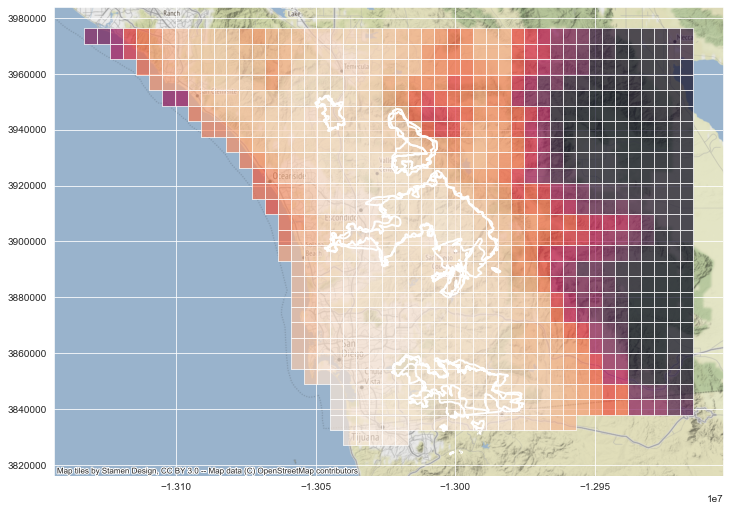

In [15]:
f, ax = plt.subplots(1, figsize=(12, 12))
DATE = '2007-10-24' # Date of the Witch Fire
dt = pd.to_datetime(DATE)
gdf.loc[dt, :].plot(ax=ax, column='probability_of_fire', alpha=0.7, vmin=0, vmax=1)
mask = sd_perimeters.perimeter_ == DATE
sd_perimeters[mask].plot(ax=ax, facecolor='None',edgecolor='white', linewidth=2)
ctx.add_basemap(ax)

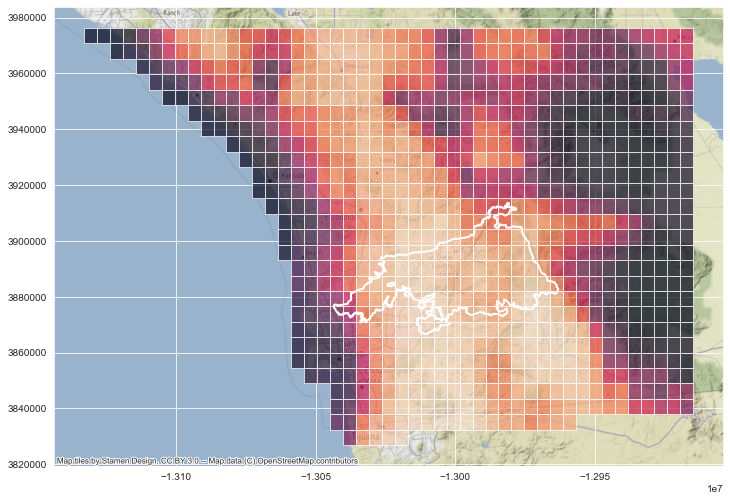

In [16]:
f, ax = plt.subplots(1, figsize=(12, 12))
DATE = '2003-10-25' # Cedar fire
dt = pd.to_datetime(DATE)
gdf.loc[dt, :].plot(ax=ax, column='probability_of_fire', alpha=0.7, vmin=0, vmax=1)
mask = sd_perimeters.alarm_date == DATE
sd_perimeters[mask].plot(ax=ax, facecolor='None',edgecolor='white', linewidth=2)
ctx.add_basemap(ax)